In [213]:
using ModelingToolkit, DifferentialEquations, Plots

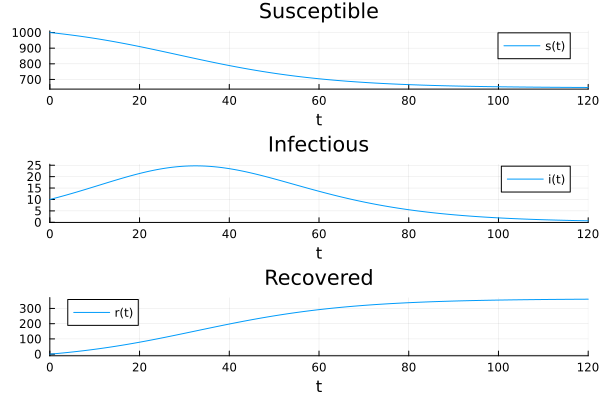

In [214]:

# Define our state variables: state(t) = initial condition
@variables t s(t)=1000 i(t)=10 r(t)=0
@parameters β=0.3 γ=1/4 N=1000

D = Differential(t)

model = [   D(s) ~ - (β * i/ N) * s,
            D(i) ~ (β * i/ N) * s - γ * i,
            D(r) ~ γ * i]

@named ode_model = ODESystem(model, t)

# Convert from a symbolic to a numerical problem to simulate
tspan = (0.0, 120.0)
prob  = ODEProblem(ode_model, [], tspan)

############ PLOTS ############

# Solve the ODE
sol = solve(prob)

# Plot the solution
p1 = plot(sol, idxs=s, title = "Susceptible")
p2 = plot(sol, idxs=i, title = "Infectious")
p3 = plot(sol, idxs=r, title = "Recovered")

plot(p1, p2, p3, layout = (3, 1))


## sir with functions

In [215]:

function sir_model(dx, x, θ, t)
    s, i, r = x
    β, γ, N = θ

    λ = β * i / N

    dx[1] = - λ * s
    dx[2] = λ * s - γ * i
    dx[3] = γ * i
end

sir_model (generic function with 1 method)

In [216]:
N  = 1e6
i0 = 2/100

# IV
x0 = [N*(1-i0), N*i0, 0]

# Simulation interval
tspan = (0.0, 120.0)

R0 = 3.0
γ  = 1/7

# θ = [α, β, N]
p       = [R0*γ, γ, N]

sir_ode = ODEProblem(sir_model, x0, tspan, p)
ysim    = solve(sir_ode, saveat = 1)
data    = Array(ysim)


3×121 Matrix{Float64}:
 980000.0      9.70375e5      9.57874e5  …  58071.8        58071.7
  20000.0  26335.1        34513.7               3.52196        3.13004
      0.0   3290.05        7612.03              9.41925e5      9.41925e5

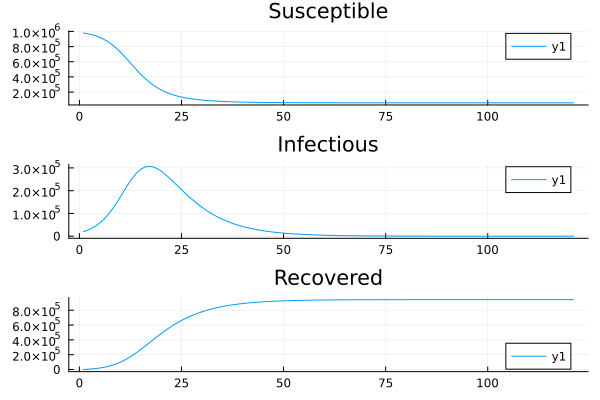

In [217]:
# Plot the solution
p1 = plot(data[1,:], title = "Susceptible")
p2 = plot(data[2,:], title = "Infectious")
p3 = plot(data[3,:], title = "Recovered")

plot(p1, p2, p3, layout = (3, 1))


# Stochastic simulation

In [218]:
using Random, Distributions, RandomNumbers


In [219]:


function binomial_transition(x, τ, δτ=1)
    rate = 1 .- exp.(-τ .* δt)
    return rand.(Binomial.(x, rate))
end


x = 1000 * ones(3,3)
τ = rand(3,3)

3×3 Matrix{Float64}:
 0.200492  0.379952  0.455197
 0.497203  0.266909  0.464974
 0.35498   0.498027  0.738867

In [230]:


function sir_stochastic(x, θ, t)
    β, γ, N, δt = θ

    s = x[1, :]
    i = x[2, :]
    r = x[3, :]

    λ = β .* i ./ N

    s2i .= binomial_transition(s, λ, δt)
    i2r .= binomial_transition(i, γ, δt)

    s .= s .- s2i
    i .= i .+ s2i .- i2r
    r .= r .+ i2r

    return transpose(cat(s, i, r, dims=2))
end

R0 = 2.0
γ  = 1/5
N  = 1e6
δt = 1.0

θ  = [R0*γ, γ, N, δt]
x0 = [N*(1-i0), N*i0, 0] * ones(Float64, 1, 300);

T = 265
n = 3
m = 300

x         = Array{Float64}(undef, T, n,m)
x[1,:,:] .= x0;

for t in 1:T-1
    x[t+1,:,:] = sir_stochastic(x[t,:,:], θ, t)
end


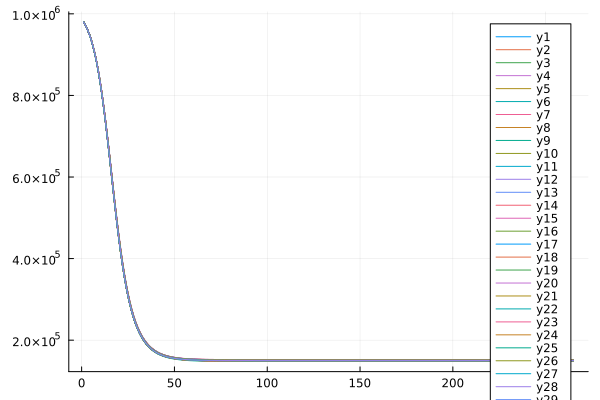

In [231]:
plot(LinRange(1, T, T), x[:,1,:])

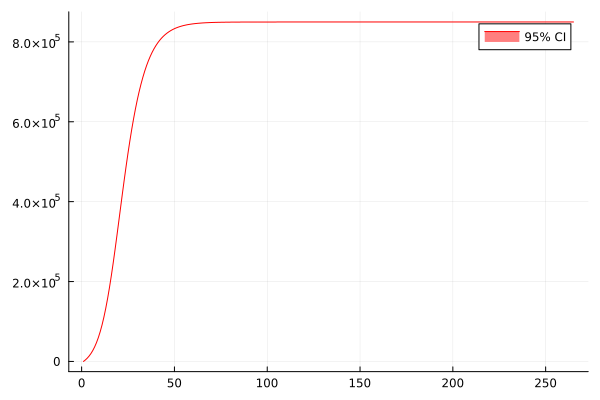

In [236]:
using Statistics

q     = 0.95

up_q  = quantile.(eachrow(x[:,3,:]), q/2)
low_q = quantile.(eachrow(x[:,3,:]), 1-q/2)

plot(LinRange(1, T, T), low_q, fillrange = up_q, fillalpha = 0.5, c = "red", label = "95% CI", legend = :topright)
